# Load module

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import norm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
import os
print(os.listdir("../data/processed/house"))

['df_fe_transformed.pickle', 'house.pkl', 'global_internal_obj_example.pkl', 'local_internal_obj_example.pkl', 'predicted_table.pkl']


# Load data

In [4]:
import joblib


filename = '../data/processed/house/df_fe_transformed.pickle'
df = joblib.load(filename)
df.head(3)

Id  MSSubClass  MSZoning  LotFrontage  LotArea  Alley  LotShape  \
0   1           0         0         65.0     8450      0         0   
1   2           1         0         80.0     9600      0         0   
2   3           0         0         68.0    11250      0         1   

   LandContour  LotConfig  LandSlope  ...  GarageArea_log  WoodDeckSF_log  \
0            0          0          0  ...        6.308098        0.000000   
1            0          1          0  ...        6.133398        5.700444   
2            0          0          0  ...        6.411818        0.000000   

   OpenPorchSF_log  EnclosedPorch_log  3SsnPorch_log  ScreenPorch_log  \
0         4.127134                0.0            0.0              0.0   
1         0.000000                0.0            0.0              0.0   
2         3.761200                0.0            0.0              0.0   

   PoolArea_log  MiscVal_log  YearRemodAdd_log  TotalSF_log  
0           0.0          0.0          7.602900     7.850493  
1           0.0          0.0          7.589336     7.833996  
2           0.0          0.0          7.602401     7.903596  

[3 rows x 132 columns]

In [23]:
total, colnum = df.shape
total

2911

In [24]:
zeor_stat = {}

In [26]:
colname = 'GarageArea_log'
zero_cnt = len(df[df['GarageArea_log']==0])
zeor_stat[colname] = 100* zero_cnt/total
zeor_stat

{'GarageArea_log': 5.39333562349708}

157


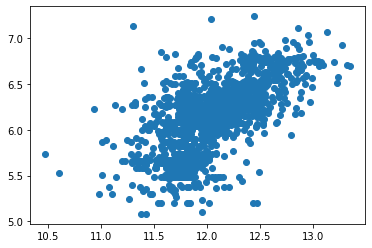

In [19]:
plt.scatter('SalePrice', colname, data=df[df['GarageArea_log']>0])
plt.show()

In [34]:
sns.set() # Setting seaborn as default style even if use only matplotlib
sns.axes_style('white')

{'figure.facecolor': 'white',
 'axes.labelcolor': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'axes.axisbelow': True,
 'grid.linestyle': '-',
 'text.color': '.15',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'xtick.top': False,
 'ytick.right': False,
 'axes.grid': False,
 'axes.facecolor': 'white',
 'axes.edgecolor': '.15',
 'grid.color': '.8',
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'xtick.bottom': False,
 'ytick.left': False}

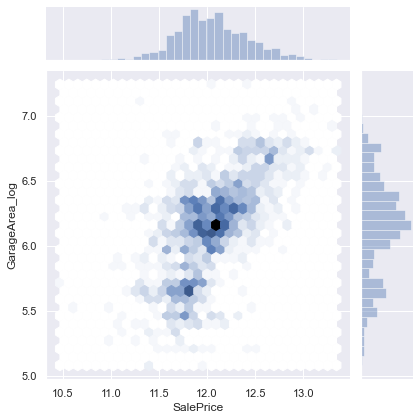

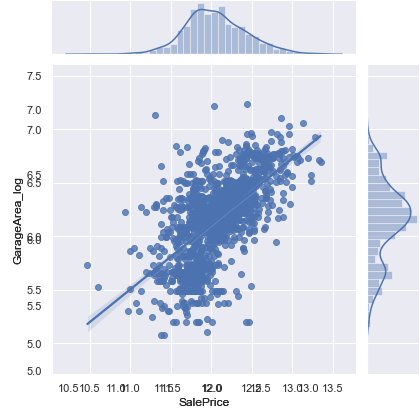

In [39]:
df_temp = df[df['GarageArea_log']>0]
JG1 = sns.jointplot("SalePrice", colname, data=df_temp, kind='hex')
JG2 = sns.jointplot("SalePrice", colname, data=df_temp, kind='reg')

#subplots migration
f = plt.figure()
for J in [JG1, JG2]:
    for A in J.fig.axes:
        f._axstack.add(f._make_key(A), A)
        
        
#subplots size adjustment
# f.axes[0].set_position([0.05, 0.05, 0.4,  0.4])
# f.axes[1].set_position([0.05, 0.45, 0.4,  0.05])
# f.axes[2].set_position([0.45, 0.05, 0.05, 0.4])
# f.axes[3].set_position([0.55, 0.05, 0.4,  0.4])
# f.axes[4].set_position([0.55, 0.45, 0.4,  0.05])
# f.axes[5].set_position([0.95, 0.05, 0.05, 0.4])

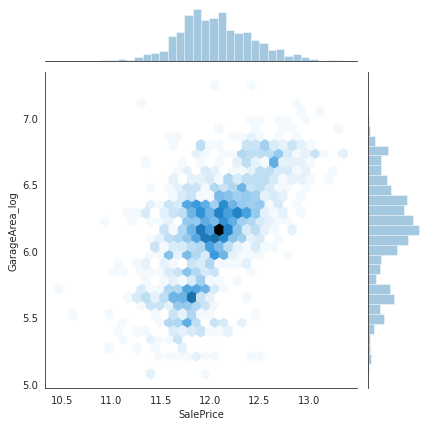

In [29]:
with sns.axes_style('white'):
    sns.jointplot("SalePrice", colname, df[df['GarageArea_log']>0], kind='hex')

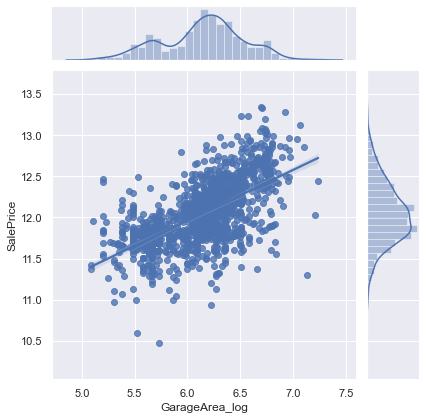

In [58]:
sns.jointplot(colname, "SalePrice", data=df[df['GarageArea_log']>0], kind='reg')


/Users/hakminkim/opt/anaconda3/envs/pycaret_test/lib/python3.8/site-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


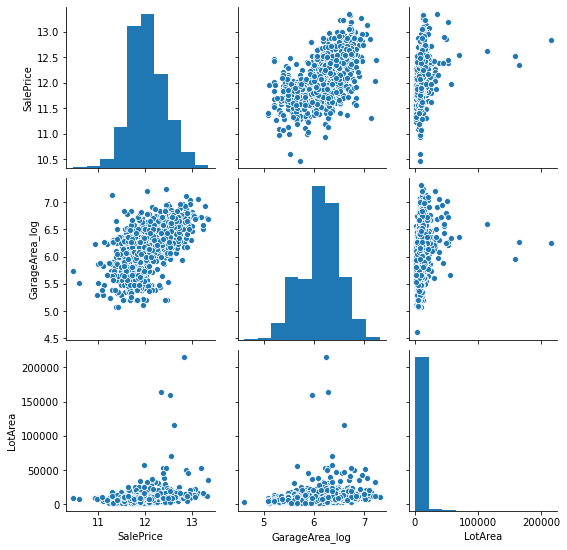

In [32]:
df_temp = df[['SalePrice','GarageArea_log','LotArea', 'OverallQual']]
df_temp = df_temp[df_temp['GarageArea_log']>0]
             
sns.pairplot(df_temp, size=2.5);


## SNS Jointplot in subplot
* https://jehyunlee.github.io/2020/10/03/Python-DS-35-seaborn_matplotlib2/

In [ ]:
# 사용법
'''
jointplots(["bill_length_mm",      #x1
            "bill_depth_mm",       #x2 
            "flipper_length_mm"],  #x3 
            "body_mass_g",         #y
            penguins,              #df
            hue="species", height=8, ratio=5, space=0.03, 
            xlabels=["Bill Length (mm)", "Bill Depth (mm)", "Flipper Length (mm)"], 
            ylabel="Body Mass (g)")
'''

In [40]:
def jointplots(xs, y, data, hue=None, height=6, ratio=5, space=0.2, xlabels=None, ylabel=None, margin_norm=False):
    """
    -------------------
    Input Parameters
    -------------------
    xs      : (list or str) feature name(s) of data
    y       : (str) feature name of data
    data    : (pandas.DataFrame)
    hue     : (str) semantic variable that is mapped to determine the color of plot elements. Semantic variable that is mapped to determine the color of plot elements.
    
    height  : (float) size of the figure
    ratio   : (float) ratio of the joint axes height to marginal axes height.
    space   : (float) space between the joint and marginal axes
    
    xlabels : (list or str) xlabels
    ylabel  : (str) ylabel
    margin_norm : (boolean) if True, kdeplots at marginal axes have same scale.
    """
    ### 1. input check
    # input type
    assert isinstance(xs, list) or isinstance(xs, str)
    if isinstance(xs, list):
        assert all([isinstance(x, str) for x in xs])
    else:
        xs = [xs]
        
    
    if xlabels != None:
        assert isinstance(xlabels, list) or isinstance(xlabels, str)
        if isinstance(xlabels, list):
            assert all([isinstance(xlabel, str) for xlabel in xlabels])
        else:
            xlabels = [xlabels]
    
    if ylabel != None:
        assert isinstance(ylabel, str)
    
    if hue != None:
        assert isinstance(hue, str)
    
    # input data
    assert all([x in data.columns for x in xs])
    assert y in data.columns
    if hue != None:
        assert hue in data.columns
    
    
    ### 2. figure
    h_margin = height / (ratio + 1)
    h_joint = height - h_margin
    
    if isinstance(xs, list):
        n_x = len(xs)
    else:
        n_x = 1
    
    widths = [h_joint] * n_x + [h_margin]
    heights = [h_margin, h_joint]
    ncols = len(widths)
    nrows = len(heights)
    
    fig = plt.figure(figsize=(sum(widths), sum(heights)))
    
    ### 3. gridspec preparation
    spec = fig.add_gridspec(ncols=ncols, nrows=nrows, 
                            width_ratios = widths, height_ratios = heights,
                            wspace=space, hspace=space
                           )
    
    ### 4. setting axes
    axs = {}
    for i in range(ncols * nrows):
        axs[i] = fig.add_subplot(spec[i//ncols, i%ncols])
    
    
    ### 5. jointplots (scatterplot + kdeplot)
    for i, x in enumerate(xs, ncols):
        if i == ncols:
            legend=True
        else:
            legend=False
        sns.kdeplot(x=x, y=y, data=data, hue=hue, alpha=0.3, ax=axs[i], zorder=2, legend=False)
        sns.scatterplot(x=x, y=y, data=data, hue=hue, alpha=0.8, ax=axs[i], zorder=3, legend=legend)
    
    
    ### 6. kdeplots at marginal axes
    axs[ncols-1].axis("off")
    
    axes_mx = list(range(ncols-1))
    axes_my = 2*ncols - 1
    
    for i, x in zip(axes_mx, xs):
        sns.kdeplot(x=x, data=data, hue=hue, fill=True, ax=axs[i], zorder=2, legend=False)
        axs[i].set_xlim(axs[i+ncols].get_xlim())
        axs[i].set_xlabel("")
        axs[i].set_xticklabels([])
        axs[i].spines["left"].set_visible(False)
        axs[i].spines["top"].set_visible(False)
        axs[i].spines["right"].set_visible(False)
    
    sns.kdeplot(y=y, data=data, hue=hue, fill=True, ax=axs[axes_my], zorder=2, legend=False)
    axs[axes_my].set_ylim(axs[ncols].get_ylim())
    axs[axes_my].set_ylabel("")
    axs[axes_my].set_yticklabels([])
    axs[axes_my].spines["bottom"].set_visible(False)
    axs[axes_my].spines["top"].set_visible(False)
    axs[axes_my].spines["right"].set_visible(False)
    
    if margin_norm == True:
        hist_range_max = max([axs[m].get_ylim()[-1] for m in axes_mx] + [axs[axes_my].get_xlim()[-1]])
        for i in axes_mx:
            axs[i].set_ylim(0, hist_range_max)
        axs[axes_my].set_xlim(0, hist_range_max)
        
        
    ### 7. unnecessary elements removal
    # 7.1. labels and ticklabels
    axes_j = list(range(ncols, 2*ncols-1))
    for i in axes_j:
        if i != ncols:
            axs[i].set_ylabel("")
            axs[i].set_yticklabels([])
    
    # 7.2. marginal axes
    for i in axes_mx:
        if i != 0:
            axs[i].set_ylabel("")
        
        axs[i].grid("on", color="lightgray", zorder=0)
        axs[i].set_yticklabels([])
        
        yticks = axs[i].get_yticks()
        ylim = axs[i].get_ylim()
        for ytick in yticks:
            if 0 < ytick < ylim[-1]:
                axs[i].text(axs[i].get_xlim()[0], ytick, str(ytick), 
                            fontdict={"verticalalignment":"center"})
        
    axs[axes_my].grid("on", color="lightgray", zorder=0)
    axs[axes_my].set_xticklabels([])
    axes_my_xticks = axs[axes_my].get_xticks()
    axes_my_xlim = axs[axes_my].get_xlim()
    for xtick in axes_my_xticks:
        if 0 < xtick < axes_my_xlim[-1]:
            axs[axes_my].text(xtick, axs[axes_my].get_ylim()[0], str(xtick), 
                              rotation=270, fontdict={"horizontalalignment":"center"})
    
    # 7.3. labels
    font_label = {"color": "gray", "fontsize":"large"}
    labelpad = 12
    for i, x in zip(axes_j, xlabels):
        axs[i].set_xlabel(x, fontdict=font_label, labelpad=labelpad)
        if i == ncols:
            axs[i].set_ylabel(ylabel, fontdict=font_label, labelpad=labelpad)
    
    axs[0].set_ylabel("Density", fontdict=font_label, labelpad=labelpad)
    axs[2*ncols-1].set_xlabel("Density", fontdict=font_label, labelpad=labelpad)
    
    fig.align_ylabels([axs[0], axs[ncols]])
    fig.align_xlabels([axs[x] for x in range(ncols, 2*ncols)])
    plt.tight_layout()
    
    return fig, axs

In [45]:
df_temp = df[['SalePrice','GarageArea_log','LotArea', 'TotalBsmtSF']]
df_temp = df_temp[df_temp['GarageArea_log']>0]
df_temp.head(3)

SalePrice  GarageArea_log  LotArea  TotalBsmtSF
0  12.247699        6.308098     8450        856.0
1  12.109016        6.133398     9600       1262.0
2  12.317171        6.411818    11250        920.0

/Users/hakminkim/opt/anaconda3/envs/pycaret_test/lib/python3.8/site-packages/seaborn/distributions.py:690: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


TypeError: _bivariate_kdeplot() got multiple values for argument 'x'

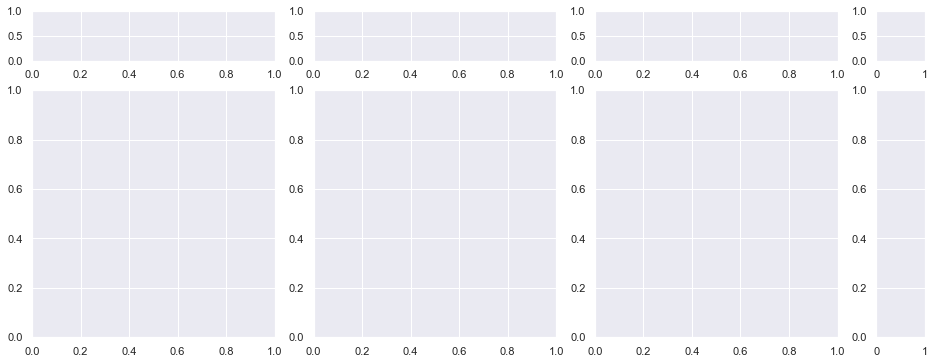

In [46]:
jointplots(["TotalBsmtSF",      #x1
            "LotArea",          #x2 
            "GarageArea_log"],  #x3 
            "SalePrice",        #y
            df_temp)                 #df

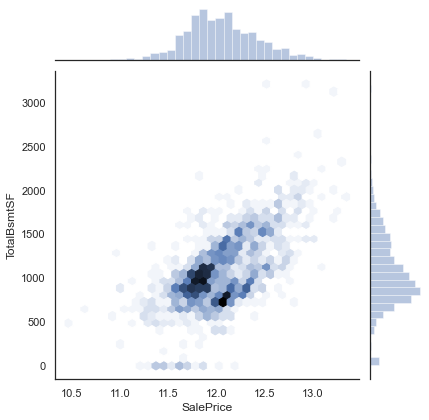

In [48]:
with sns.axes_style('white'):
    sns.jointplot("SalePrice", "TotalBsmtSF", df_temp, kind='hex')

In [57]:
with sns.axes_style('white'):
    sns.jointplot("LotArea", "SalePrice", df[df["LotArea"]<30000], kind='hex')

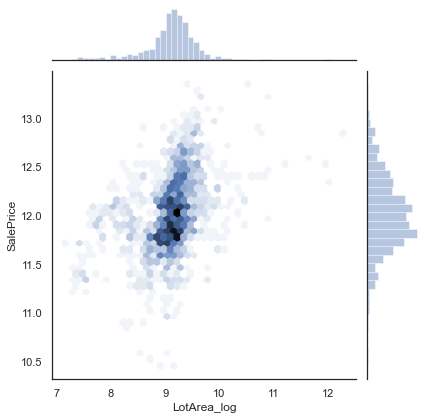

In [56]:
with sns.axes_style('white'):
    sns.jointplot("LotArea_log", "SalePrice", df, kind='hex')